In [1]:
# Plot the first figure, with the MUR SST, the TSG SST from the two ships, and some ERA5 fields, to show the
# large-scale dynamics a bit (two day averages).

In [1]:
# Import relevant modules
import xarray as xr
import numpy as np
import pydap
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cfeature           # import features
import uuid
from scipy import interpolate
import scipy.io
from glob import glob
import os
from matplotlib.offsetbox import AnchoredText

In [2]:
area_str = 'eurec4a cold patch'; area_name = 'Cold patch EUREC4A'
minlon = -58; maxlon = -50; minlat = 5; maxlat = 10;

extent_param = [minlon, maxlon, minlat, maxlat]
crs = ccrs.PlateCarree()

def plot_background(ax):
    ax.set_extent(extent_param)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    #ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'fontsize': 14}
    gl.ylabel_style = {'fontsize': 14}
    return ax

In [3]:
# Set the relevant paths.

path2atlQCTSG = '/home/agostino/SST-impact_data/'
path2merQCTSG = '/share/eureca_data/Merian/TSG_QC/'
path2MURSST = '/share/eureca_data/Satellites/MUR/'
path2ERA5 = '/home/agostino/eureca_era5_analysis/'

In [4]:
# Define the time window of interest YYYY-MM-DD
datestr_start = '2020-02-02'
datestr_end = '2020-02-04'

date_start = np.datetime64(datestr_start)
date_end = np.datetime64(datestr_end)

date_sst_map = '2020-02-02'

list_of_days = ['20200202','20200203'] # For the RS reading

In [5]:
# Read the MUR SST data.
filename_mur = path2MURSST + 'SST_MUR_' + date_sst_map + '.nc'
filename_mur_grid = path2MURSST + 'SST_MUR_Grid.nc'

ds_mur = xr.open_dataset(filename_mur)
ds_mur.close()
ds_mur_grid = xr.open_dataset(filename_mur_grid)
ds_mur_grid.close()

sst_mur = ds_mur['sst_MUR'].values
sst_mur_lon = ds_mur_grid['X_SST_MUR'].values
sst_mur_lat = ds_mur_grid['Y_SST_MUR'].values

In [6]:
# Read the Atalante QC TSG data.
filename_dat = path2atlQCTSG + 'Atalante_traj_gosud3_2001-18022020-cor'

# Read the dat file.
ndf = pd.read_csv(filename_dat, delimiter='\s+', header=None, engine='python',
                  names=['year','month','day','hour','minute','second', 'lon', 'lat', 'salt', 'temp', 'bho'])

df = pd.DataFrame({'year': ndf.year,
                   'month': ndf.month,
                   'day': ndf.day,
                   'hour': ndf.hour,
                   'minute': ndf.minute,
                   'second': ndf.second})
time_atlqctsg = pd.to_datetime(df)
lon_atlqctsg = ndf.lon
lat_atlqctsg = ndf.lat

# Remove the outliers.
temp_atlqctsg = ndf.temp
temp_atlqctsg[ndf.temp>28] = np.NaN

idtime_atlqctsg = (time_atlqctsg>date_start) & (time_atlqctsg<date_end)

<ipython-input-6-aa7634d40a9a>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_atlqctsg[ndf.temp>28] = np.NaN


In [7]:
# Read the Merian QC TSG data.
filename_nc = path2merQCTSG + 'msm_089_1_tsg.nc'
ds = xr.open_dataset(filename_nc)
ds.close()

temp0 = ds.TEMP[:,0].values
temp1 = ds.TEMP[:,1].values
temp_merqctsg = temp0
temp_merqctsg[np.isnan(temp0)] = temp1[np.isnan(temp0)]
temp_merqctsg[temp_merqctsg<26] = np.NaN

lon_merqctsg = ds.LONGITUDE.values
lat_merqctsg = ds.LATITUDE.values
time_merqctsg = ds.TIME.values

idtime_merqctsg = (time_merqctsg>date_start) & (time_merqctsg<date_end)
ii0_merqctsg = np.argmax(idtime_merqctsg) # First instant of the time frame selected

In [8]:
# Read the ERA5 data.
ds_single = xr.open_dataset(path2ERA5+'cold_path_single_lev_era5_feb2020.nc')

sst_2_3 = ds_single['sst'].sel(time=slice('2020-02-02','2020-02-03')).mean(dim='time',skipna='True')
cbh_2_3 = ds_single['cbh'].sel(time=slice('2020-02-02','2020-02-03')).mean(dim='time',skipna='True')
lcc_2_3 = ds_single['lcc'].sel(time=slice('2020-02-02','2020-02-03')).mean(dim='time',skipna='True')
blh_2_3 = ds_single['blh'].sel(time=slice('2020-02-02','2020-02-03')).mean(dim='time',skipna='True')
slhf_2_3 = ds_single['slhf'].sel(time=slice('2020-02-02','2020-02-03')).mean(dim='time',skipna='True')
u10_2_3 = ds_single['u10'].sel(time=slice('2020-02-02','2020-02-03')).mean(dim='time',skipna='True')
v10_2_3 = ds_single['v10'].sel(time=slice('2020-02-02','2020-02-03')).mean(dim='time',skipna='True')

lon_warm = -52.75; lat_warm = 8.25 # date_2 = '2020-02-02T00:00:00' on the R/V Atalante trajectory.
lon_cold = -54.4; lat_cold = 6.5 # date_3 = '2020-02-03T12:00:00' on the R/V Atalante trajectory.
dlon = 0.5; dlat = 0.5

date_2 = '2020-02-02T00:00:00'
date_3 = '2020-02-03T06:00:00'

lon_sst = ds_single['longitude'].values
lat_sst = ds_single['latitude'].values
sst_avg = sst_2_3.values
blh_avg = blh_2_3.values
u10_avg = u10_2_3.values
v10_avg = v10_2_3.values
mask_nan = sst_avg/sst_avg

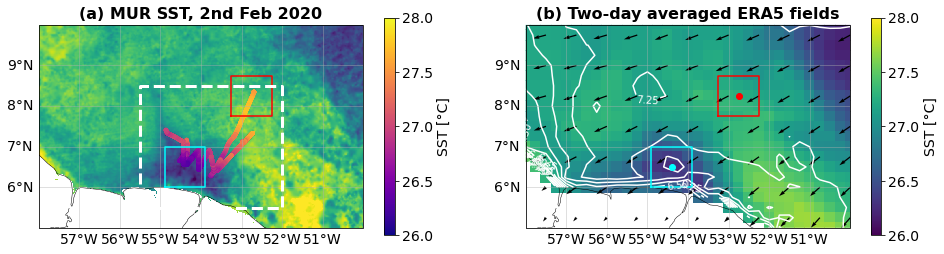

In [9]:
# Plot the figure with two panels showing the same area.
# Left panel: MUR SST map + TSG SST series (with another colorbar)
# Right panel: ERA5 SST map (one day or a weekly average) + ERA5 wind speed (contour and quiver) +
# boxes for the analyses.

fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(1, 2, 1, projection=crs)
plot_background(ax1)
ax2 = fig.add_subplot(1, 2, 2, projection=crs)
plot_background(ax2)

vmin_sst=26.; vmax_sst=28.

# observed SST
#ax1.scatter(lon_atlqctsg[idtime_atlqctsg],lat_atlqctsg[idtime_atlqctsg],s=12,c='k')
pc1 = ax1.pcolormesh(sst_mur_lon,sst_mur_lat,sst_mur,vmin=vmin_sst,vmax=vmax_sst)
sc1 = ax1.scatter(lon_atlqctsg[idtime_atlqctsg],lat_atlqctsg[idtime_atlqctsg],s=12,
                  c=temp_atlqctsg[idtime_atlqctsg],vmin=vmin_sst,vmax=vmax_sst,cmap='plasma')
ax1.scatter(lon_merqctsg[idtime_merqctsg],lat_merqctsg[idtime_merqctsg],s=12,c=temp_merqctsg[idtime_merqctsg],
           vmin=vmin_sst,vmax=vmax_sst,cmap='plasma')

#pc1 = ax1.pcolor(lon_sst,lat_sst,l3u_sst-273.15,vmin=sst_vmin,vmax=sst_vmax,shading='nearest')
cbar1 = plt.colorbar(sc1,ax=ax1)#,location='bottom',shrink=0.75)
cbar1.set_label('SST [°C]', fontsize=14)
cbar1.ax.tick_params(labelsize=14)
#ax1.set_title(instant_sst,fontsize=16)

ax1.plot([lon_warm-dlon,lon_warm+dlon,lon_warm+dlon,lon_warm-dlon,lon_warm-dlon],
        [lat_warm-dlat,lat_warm-dlat,lat_warm+dlat,lat_warm+dlat,lat_warm-dlat],'r')
ax1.plot([lon_cold-dlon,lon_cold+dlon,lon_cold+dlon,lon_cold-dlon,lon_cold-dlon],
        [lat_cold-dlat,lat_cold-dlat,lat_cold+dlat,lat_cold+dlat,lat_cold-dlat],'cyan')
ax1.set_title('(a) MUR SST, 2nd Feb 2020',fontsize=16,fontweight='bold')

# Rectangle where analyses are done
ax1.plot([-55.5, -52, -52, -55.5, -55.5],[5.5, 5.5, 8.5, 8.5, 5.5],'--w',linewidth = 3)

# ERA5 fields
wspd10_avg = np.sqrt(u10_avg**2+v10_avg**2)
#cs = ax2.contour(lon_sst,lat_sst,sst_avg-273.15,colors='w')
#plt.clabel(cs)
#pc = ax2.pcolor(lon_sst,lat_sst,wspd10_avg*mask_nan,shading='nearest',vmin=6.5,vmax=7.5)
cs = ax2.contour(lon_sst,lat_sst,wspd10_avg*mask_nan,np.arange(1,10,0.25),colors='w')
plt.clabel(cs)
pc = ax2.pcolor(lon_sst,lat_sst,sst_avg-273.15,shading='nearest',vmin=vmin_sst,vmax=vmax_sst)
step = 3
plt.quiver(lon_sst[::step],lat_sst[::step],u10_avg[::step,::step],v10_avg[::step,::step])

ax2.plot([lon_warm-dlon,lon_warm+dlon,lon_warm+dlon,lon_warm-dlon,lon_warm-dlon],
        [lat_warm-dlat,lat_warm-dlat,lat_warm+dlat,lat_warm+dlat,lat_warm-dlat],'r')
ax2.plot([lon_cold-dlon,lon_cold+dlon,lon_cold+dlon,lon_cold-dlon,lon_cold-dlon],
        [lat_cold-dlat,lat_cold-dlat,lat_cold+dlat,lat_cold+dlat,lat_cold-dlat],'cyan')
ax2.plot(lon_warm,lat_warm,'or')
ax2.plot(lon_cold,lat_cold,'o',mec='cyan',mfc='cyan')#'darkblue')

plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)

ax2.set_title('(b) Two-day averaged ERA5 fields',fontsize=16,fontweight='bold')
cbar2 = plt.colorbar(pc)
cbar2.ax.tick_params(labelsize=14) 
cbar2.set_label('SST [°C]',fontsize=14)

#ws_vmin = 0; ws_vmax = 15;
#wspd = np.sqrt(u_interp**2+v_interp**2)
#pc2 = ax2.pcolor(lon_sst,lat_sst,wspd,vmin=ws_vmin,vmax=ws_vmax,shading='nearest',cmap='inferno')
#cbar2 = plt.colorbar(pc2,ax=ax2,location='bottom',shrink=0.75)
#cbar2.set_label('Wind speed [m/s]',fontsize=14)
#cbar2.ax.tick_params(labelsize=14) 
#ax2.set_title(instant_wind,fontsize=16)

# Subplot label
#anchored_text1 = AnchoredText('(a)', loc=2, prop=dict(size=14), frameon=False); ax1.add_artist(anchored_text1)
#anchored_text2 = AnchoredText('(b)', loc=2, prop=dict(size=14), frameon=False); ax2.add_artist(anchored_text2)

figure_name = 'fig1.png'
plt.savefig(figure_name,bbox_inches='tight')

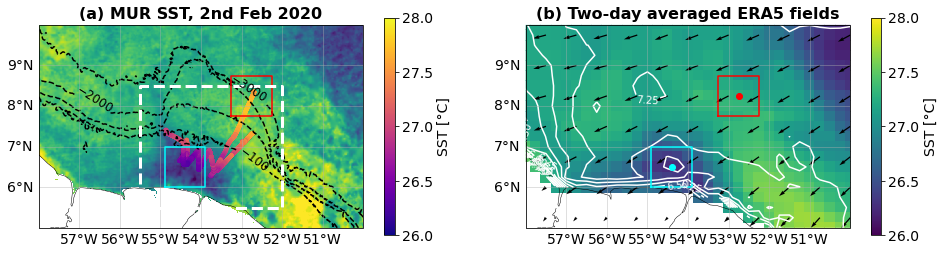

In [50]:
# Add the bathymetry in the left panel from GEBCO data.

fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(1, 2, 1, projection=crs)
plot_background(ax1)
ax2 = fig.add_subplot(1, 2, 2, projection=crs)
plot_background(ax2)

vmin_sst=26.; vmax_sst=28.

# observed SST
#ax1.scatter(lon_atlqctsg[idtime_atlqctsg],lat_atlqctsg[idtime_atlqctsg],s=12,c='k')
pc1 = ax1.pcolormesh(sst_mur_lon,sst_mur_lat,sst_mur,vmin=vmin_sst,vmax=vmax_sst)
sc1 = ax1.scatter(lon_atlqctsg[idtime_atlqctsg],lat_atlqctsg[idtime_atlqctsg],s=12,
                  c=temp_atlqctsg[idtime_atlqctsg],vmin=vmin_sst,vmax=vmax_sst,cmap='plasma')
ax1.scatter(lon_merqctsg[idtime_merqctsg],lat_merqctsg[idtime_merqctsg],s=12,c=temp_merqctsg[idtime_merqctsg],
           vmin=vmin_sst,vmax=vmax_sst,cmap='plasma')

#pc1 = ax1.pcolor(lon_sst,lat_sst,l3u_sst-273.15,vmin=sst_vmin,vmax=sst_vmax,shading='nearest')
cbar1 = plt.colorbar(sc1,ax=ax1)#,location='bottom',shrink=0.75)
cbar1.set_label('SST [°C]', fontsize=14)
cbar1.ax.tick_params(labelsize=14)
#ax1.set_title(instant_sst,fontsize=16)

ax1.plot([lon_warm-dlon,lon_warm+dlon,lon_warm+dlon,lon_warm-dlon,lon_warm-dlon],
        [lat_warm-dlat,lat_warm-dlat,lat_warm+dlat,lat_warm+dlat,lat_warm-dlat],'r')
ax1.plot([lon_cold-dlon,lon_cold+dlon,lon_cold+dlon,lon_cold-dlon,lon_cold-dlon],
        [lat_cold-dlat,lat_cold-dlat,lat_cold+dlat,lat_cold+dlat,lat_cold-dlat],'cyan')
ax1.set_title('(a) MUR SST, 2nd Feb 2020',fontsize=16,fontweight='bold')

# Rectangle where analyses are done
ax1.plot([-55.5, -52, -52, -55.5, -55.5],[5.5, 5.5, 8.5, 8.5, 5.5],'--w',linewidth=3)

ds_gebco = xr.open_dataset(path2atlQCTSG+'gebco_2022_n12.0_s5.0_w-60.0_e-50.0.nc')
lon_g = ds_gebco.lon.values
lat_g = ds_gebco.lat.values
bat = ds_gebco.elevation.values
cs_g = ax1.contour(lon_g,lat_g,bat,levels=np.array([-3000,-2000,-1000,-100]),colors='k')
#ax1.contour(lon_g,lat_g,bat,[-100],colors='lightgray', linewidths=3, label)
plt.clabel(cs_g, fontsize=12)

# ERA5 fields
wspd10_avg = np.sqrt(u10_avg**2+v10_avg**2)
#cs = ax2.contour(lon_sst,lat_sst,sst_avg-273.15,colors='w')
#plt.clabel(cs)
#pc = ax2.pcolor(lon_sst,lat_sst,wspd10_avg*mask_nan,shading='nearest',vmin=6.5,vmax=7.5)
cs = ax2.contour(lon_sst,lat_sst,wspd10_avg*mask_nan,np.arange(1,10,0.25),colors='w')
plt.clabel(cs)
pc = ax2.pcolor(lon_sst,lat_sst,sst_avg-273.15,shading='nearest',vmin=vmin_sst,vmax=vmax_sst)
step = 3
plt.quiver(lon_sst[::step],lat_sst[::step],u10_avg[::step,::step],v10_avg[::step,::step])

ax2.plot([lon_warm-dlon,lon_warm+dlon,lon_warm+dlon,lon_warm-dlon,lon_warm-dlon],
        [lat_warm-dlat,lat_warm-dlat,lat_warm+dlat,lat_warm+dlat,lat_warm-dlat],'r')
ax2.plot([lon_cold-dlon,lon_cold+dlon,lon_cold+dlon,lon_cold-dlon,lon_cold-dlon],
        [lat_cold-dlat,lat_cold-dlat,lat_cold+dlat,lat_cold+dlat,lat_cold-dlat],'cyan')
ax2.plot(lon_warm,lat_warm,'or')
ax2.plot(lon_cold,lat_cold,'o',mec='cyan',mfc='cyan')#'darkblue')

plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)

ax2.set_title('(b) Two-day averaged ERA5 fields',fontsize=16,fontweight='bold')
cbar2 = plt.colorbar(pc)
cbar2.ax.tick_params(labelsize=14) 
cbar2.set_label('SST [°C]',fontsize=14)

figure_name = 'fig1_with_gebco_bathymetry.png'
plt.savefig(figure_name,bbox_inches='tight')